In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
%matplotlib inline

In [21]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def get_points(fitted_line,image):
    """
    This function returns the two points (x1,y1) , (x2,y2) to draw the fitted line using parameters (m,b)
    """
    slope,intersect = fitted_line
    # first vertical point start @ the end of the image
    y1 = image.shape[0] # get the hight of image which represents the buttom
    
    y2 = 290 #  i think its enough to draw lines till the half of the image
    
    # using the equation of line y = m*x + b we can get x values of y1 & y2
    # m = fitted_line[0] , b = fitted_line[1]
    x1 = int ((y1-intersect) / (slope))
    x2 = int ((y2-intersect) / (slope))
    
    return np.array([x1,y1,x2,y2])
def line_seperation(lines,image):
    """
    This function seprates 'lines' ie : seperate left and right lane lines
    The key concept is that the slope of the left lane line decreasing and the slope of the right lane line increasing
    
    """

    left_lane  = []  # holds the left segment lanes
    right_lane = []  # holds the right segment lanes
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            line_parameters = np.polyfit((x1,x2),(y1,y2),1)
            
            slope = line_parameters[0]     # get the slope of the line (m)
            intersect = line_parameters[1] # get the intersect of line (b)
            if slope < 0 : # left segment as the slope decreasing
                left_lane.append((slope,intersect))
            if slope > 0 : # right segment as the slope increasing
                right_lane.append((slope,intersect))
                
    left_lane_average =  np.average(left_lane,axis=0)
    right_lane_average =  np.average(right_lane,axis=0)
    left_fit  = get_points(left_lane_average,image)
    right_fit = get_points(right_lane_average,image)
    
    return np.array([[left_fit],[right_fit]])
    # converting to numpy array to prevent modifications in drawing on image            
    #left_lane = np.array(left_lane)
    #right_lane = np.array(right_lane)
    

    #return left_lane,right_lane   

def get_line_parameters(line):
    """
    This function gets the parameters of line ( slope(m) and intersection(b))
    """
    # seperate x points from y points 
    x_points = []
    y_points = []
    for points in line:
        for x1,y1,x2,y2 in points:
            x_points.append(x1)
            x_points.append(x2)
            y_points.append(y1)
            y_points.append(y2)
    
    x_points = np.array(x_points)
    y_points = np.array(y_points)
    
    # get the best fit line     
    m, b = np.polyfit(x_points, y_points, 1)
    
    best_fit_line = m*x_points+b

    row = []
    result = []
    i=1
    for x,y in zip(x_points, best_fit_line):
        row.append(x)
        row.append(int(y))
        
        if i == 2:
            i=0
            result.append([row])
            row = [] # clear list
        i +=1     

    result = np.array(result)
    print("drawing best fit line")
    plt.plot(x_points,best_fit_line)
    plt.show()
    return result    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    left_lane,right_lane = line_seperation(lines,img)
    lanes = line_seperation(lines,img)
    #left_fit = get_line_parameters(left_lane)
    #right_fit = get_line_parameters(right_lane)
    #draw_lines(line_img,  np.append(left_fit,right_fit,axis=0))
    draw_lines(line_img, lanes)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


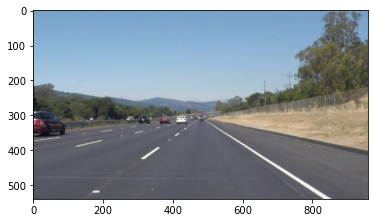

In [22]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

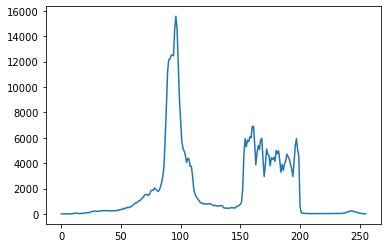

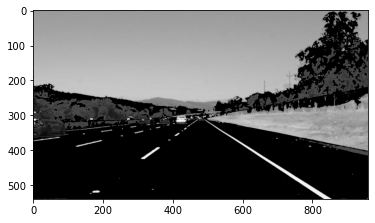

In [23]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
# first read the image 
# convert image to gray scale
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#plt.imshow(image_gray,cmap='gray')  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
# calculating the hsitogram of the image to remove the contigous parts
hist=cv2.calcHist([image_gray],[0],None,[256],[0,256]) 
plt.plot(hist)
plt.show()
for i in range(80,120):
    image_gray[image_gray == i] = 0
plt.imshow(image_gray,cmap='gray')
#vertices=np.array([[250, 200], [300, 100], [750, 800], [100, 1000]])
#roi = region_of_interest(image,np.int32([vertices]))
#plt.imshow(roi,cmap='gray')  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [24]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
# first read the image 
# convert image to gray scale
def pipline(image):
    image_gray = grayscale(image)
    print("original image")
    plt.imshow(image_gray,cmap='gray')  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    plt.show()
    
    # apply gaussian filter to image
    image_blur = gaussian_blur(image_gray,5)
    print("Blured image")
    plt.imshow(image_blur,cmap='gray')
    plt.show()

    # create canny edge detection to detect edges
    image_edges = canny(image_blur,100,300)
    print("Edges image")
    plt.imshow(image_edges,cmap='gray')
    plt.show()
    
    # apply ROI to get the region we interested 
    # left , right , vertex
    vertcies = np.array([[130,540],[900,540],[480,290]])
    roi = region_of_interest(image_edges,np.int32([vertcies]))
    print("ROI image")
    plt.imshow(roi,cmap='gray')
    plt.show()



    # detect lines using hough transform
    image_lines = hough_lines(roi, 1, np.pi/180,1, 1, 1)
    
    lines_index = np.where(image_lines != 0)
    plt.scatter(lines_index[1],lines_index[0])
    plt.show()
    print("HOUGH image")
    plt.imshow(image_lines,cmap='gray')
    plt.show()
    
    # using dilation and erotion to connect lines
    kernel = np.ones((1,5), np.uint8)  # note this is a horizontal kernel
    image_lines = cv2.dilate(image_lines, kernel, iterations=2)
    #e_im = cv2.erode(d_im, kernel, iterations=1    
    print("Dilate image")
    plt.imshow(image_lines,cmap='gray')
    plt.show()
    
    image_weighted =  weighted_img(image_lines, image, α=0.8, β=1., γ=0.)
    plt.imshow(image_weighted,cmap='gray')
    plt.show()

original image


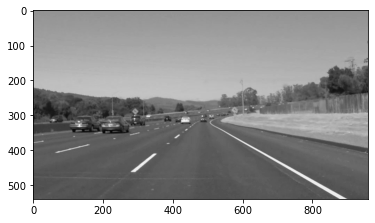

Blured image


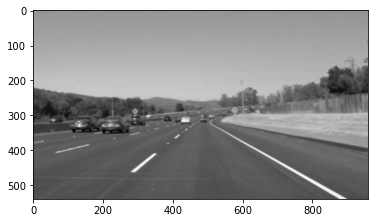

Edges image


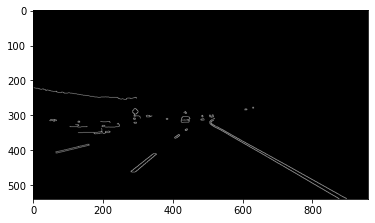

ROI image


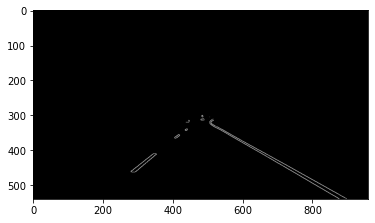

<ipython-input-21-373b9c5570d2>:166: RankWarning: Polyfit may be poorly conditioned
  left_lane,right_lane = line_seperation(lines,img)
<ipython-input-21-373b9c5570d2>:166: RankWarning: Polyfit may be poorly conditioned
  left_lane,right_lane = line_seperation(lines,img)
<ipython-input-21-373b9c5570d2>:166: RankWarning: Polyfit may be poorly conditioned
  left_lane,right_lane = line_seperation(lines,img)
<ipython-input-21-373b9c5570d2>:166: RankWarning: Polyfit may be poorly conditioned
  left_lane,right_lane = line_seperation(lines,img)
<ipython-input-21-373b9c5570d2>:166: RankWarning: Polyfit may be poorly conditioned
  left_lane,right_lane = line_seperation(lines,img)
<ipython-input-21-373b9c5570d2>:166: RankWarning: Polyfit may be poorly conditioned
  left_lane,right_lane = line_seperation(lines,img)
<ipython-input-21-373b9c5570d2>:166: RankWarning: Polyfit may be poorly conditioned
  left_lane,right_lane = line_seperation(lines,img)
<ipython-input-21-373b9c5570d2>:166: RankWarning

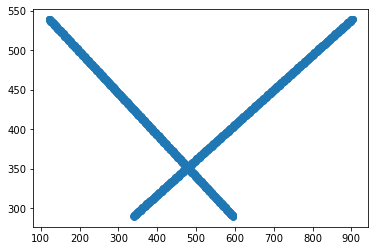

HOUGH image


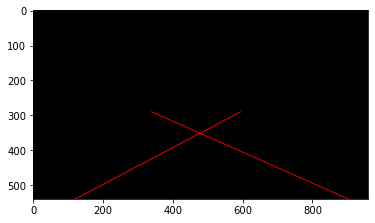

Dilate image


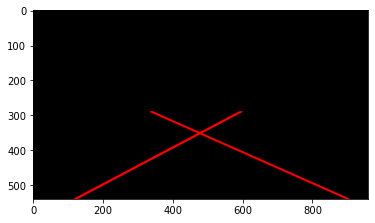

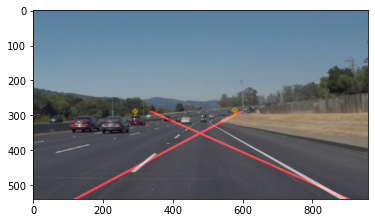

In [25]:
test_images = os.listdir("test_images/")
image = mpimg.imread('test_images/'+test_images[0])
pipline(image)


In [ ]:
for x1,x2 in [1,2,3,4]:
    print(x1)
    print(x2)

In [ ]:
x = np.append(x,[[[10,11,12,13]]],axis=0)

In [ ]:
x